In [3]:
import numpy as np
from matplotlib import pyplot as plt


In [4]:
def bytes_to_int(bytes_num):
    return int.from_bytes(read(bytes_num), byteorder='big')

def vectorized(digit):
    """
    A function that represents a digit in a vectorized form (i.e. 9 -> transposed (0,0,0,0,0,0,0,0,0,1))
    """
    arr = np.zeros((10,1))
    arr[digit] = 1
    return arr

array = np.array

ndarray = np.ndarray

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))

def partition(arr, step=1):
    part_arr = []
    for i in range(0,len(arr)-step, step):
       part_arr.append(arr[i:i+step])

    part_arr.append(arr[i:i+step])
    
    last_part = arr[i+step:]
    if last_part:
        part_arr.append(last_part)
    return part_arr

<br>

### =========================== Get All Images ===========================

In [ ]:
file_data = open('train-images.idx3-ubyte', 'rb')
read = file_data.read

# Remove magic number
magic_num = bytes_to_int(4)


# Get Dimensions
entries_count = bytes_to_int(4)
dim1 = bytes_to_int(4)
dim2 = bytes_to_int(4)

images = np.ndarray((entries_count, dim1, dim2))
for num in range(entries_count):
    image = np.zeros((dim1,dim2))
    for i in range(dim1):
        for j in range(dim2):
            image[i,j] = bytes_to_int(1)
        
    images[num] = image

In [ ]:
file_data = open('t10k-images.idx3-ubyte', 'rb')
read = file_data.read

# Remove magic number
magic_num = bytes_to_int(4)


# Get Dimensions
test_entries_count = bytes_to_int(4)
dim1 = bytes_to_int(4)
dim2 = bytes_to_int(4)

test_images = np.ndarray((test_entries_count, dim1, dim2))
for num in range(test_entries_count):
    image = np.zeros((dim1,dim2))
    for i in range(dim1):
        for j in range(dim2):
            image[i,j] = bytes_to_int(1)
        
    test_images[num] = image

<br>

### =========================== Get All Labels ===========================

In [ ]:
file_labels = open('train-labels.idx1-ubyte', 'rb')
read = file_labels.read

magic_num = read(4)

labels_count = bytes_to_int(4)
labels = np.zeros(labels_count)

for i in range(labels_count):
    labels[i] = bytes_to_int(1)

labels=labels.astype('int')

In [ ]:
file_labels = open('t10k-labels.idx1-ubyte', 'rb')
read = file_labels.read

magic_num = read(4)
magic_num

test_labels_count = bytes_to_int(4)
test_labels = np.zeros(test_labels_count)

for i in range(test_labels_count):
    test_labels[i] = bytes_to_int(1)

test_labels=test_labels.astype('int')

<br>

### =========================== Create Training Sets ===========================

In [45]:
# # Create (784,1) input vector out of 28*28 (=784) image and vectorized output vector for training
# train_set = array(list(zip([image.reshape((784,1)) for image in images[:50000]],[vectorized(label) for label in labels[:50000]])))

# # Create (784,1) input vector for validation
# validation_set = array(list(zip([image.reshape((784,1)) for image in images[50000:]],labels[50000:])))

# # Create (784,1) input vector for testing
# test_set = np.array(list(zip([image.reshape((784,1)) for image in test_images], test_labels)))


### =========================== To Save or Load =========================== 

In [7]:
# np.save('all_three_sets',np.array([train_set, validation_set, test_set]))
train_set, validation_set, test_set = np.load('all_three_sets.npy', allow_pickle=True)


<br>

### =========================== Create Network ===========================

In [32]:
class Network:
    def __init__(self, sizes):
        self.layers_num = len(sizes)
        self.sizes = sizes
        self.weights = [np.random.randn(n,m) for m,n in zip(sizes[:-1], sizes[1:])]
        self.biases = [np.random.randn(n,1) for n in sizes[1:]]

    
    def feedforward(self, x):
        for w, b in zip(self.weights, self.biases):
            x = sigmoid(np.dot(w,x)+b)
        return x

    def backprop(self , x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases ]
        nabla_w = [np.zeros(w.shape) for w in self.weights ]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations , layer by layer
        zs = [] # list to store all the z vectors , layer by layer
        for b, w in zip(self.biases , self.weights ):
            z = np.dot(w, activation ) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative( activations[-1], y) * sigmoid_prime(zs[ -1])
        nabla_b [ -1] = delta
        nabla_w [ -1] = np.dot(delta , activations[ -2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here ,
        # l = 1 means the last layer of neurons , l = 2 is the
        # second -last layer , and so on. It ’s a renumbering of the
        # scheme in the book , used here to take advantage of the fact
        # that Python can use negative indices in lists .
        for l in xrange(2, self.num_layers ):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose() , delta ) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta , activations[-l -1].transpose())
        return (nabla_b , nabla_w )

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        n = len(training_data)
        if test_data.size:
            n_test = len(test_data)
        for i in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[i:i+mini_batch_size] for i in range(0,n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_by_mini_batch(mini_batch, eta)
        
            if test_data.size:
                print(f"Epoch {i}, {self.evaluate(test_data)} / {n_test}")
            else:
                print(f"Epoch {i} completed")

    def update_by_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(biases.shape) for biases in self.biases]
        nabla_w = [np.zeros(weights.shape) for weights in self.weights]
        for img, outp in mini_batch:
            delta_biases, delta_weights = self.backprop(img,outp)
            nabla_b = [nb + db for nb,db in zip(nabla_b, delta_biases)]
            nabla_w = [nw + dw for nw, dw in zip(nabla_w, delta_weights)]
        
        self.weights = [w - eta/len(mini_batch)*nw for w,nw in zip(self.weights, nabla_w)]
        self.biases = [b - eta/len(mini_batch)*nb for b, nb in zip(self.biases, nabla_b)]

    
    def evaluate(self, test_data):
        successful_classification_arr = [(np.argmax(self.feedforward(x)) == y) for x,y in test_set]

        return sum(int(classification_result) for classification_result in successful_classification_arr)


    def cost_derivative (self , output_activations , y):
        return ( output_activations -y)
    



In [37]:
arr = list(range(100))
# print(arr)
np.random.shuffle(arr)
# print(arr)

arr = np.array(list(range(100)))
arr==arr

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

<br>


### =========================== To Display an Image ==========================

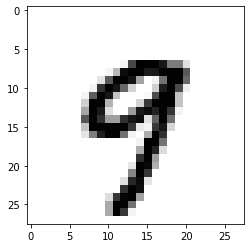

In [15]:
im_num = 45

new_image = [[[(255-val)/255]*3 for val in row] for row in train_set[im_num][0].reshape((28,28))]
plt.imshow(new_image, interpolation='nearest')
plt.show()

In [29]:
net = Network([784,30,10])
net.SGD(train_set, 1000,20,1,test_set)

NameError: name 'sigmoid_prime' is not defined

True